<a href="https://colab.research.google.com/github/1HPz/Statistical-Learning-Labs/blob/main/%E0%B8%AA%E0%B8%B3%E0%B9%80%E0%B8%99%E0%B8%B2%E0%B8%82%E0%B8%AD%E0%B8%87_229351_LAB11_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ปฏิบัติการครั้งที่ 9

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 2 ปีสุดท้ายและ Training set เป็นข้อมูลที่เหลือ
3. ลองสร้างโมเดล SARIMA อันดับต่างๆ แล้วระบุโมเดลที่ดีที่สุด
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [ ]:
# ONLY RUN THIS WHEN THERE IS AN ERROR
!pip install --user statsmodels==0.13.1

  Using cached statsmodels-0.13.1.tar.gz (18.1 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [1]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2025-09-18 02:46:11--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.47.56, 172.66.44.200, 2606:4700:310c::ac42:2cc8, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.47.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.02s   

2025-09-18 02:46:11 (5.93 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [2]:
!pip install numpy==1.26.4
!pip install pmdarima

In [3]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA


In [5]:
# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
from datetime import datetime

def parser(dates):
  return datetime.strptime(dates, '%Y-%m-%d')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],
                                        index_col='Date')

# Convert the index to datetime objects after reading the CSV
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')

data.head()

,MaxTemp
Date,
1998-01-01,30.6
1998-01-02,32.0
1998-01-03,31.6
1998-01-04,32.1
1998-01-05,31.2


ข้อมูล (สมมติว่าชื่อ `data`) ที่ load มาเป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วยคำสั่ง

In [6]:
y = data['MaxTemp'].resample("M").mean()

/tmp/ipython-input-3759875875.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = data['MaxTemp'].resample("M").mean()


In [7]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

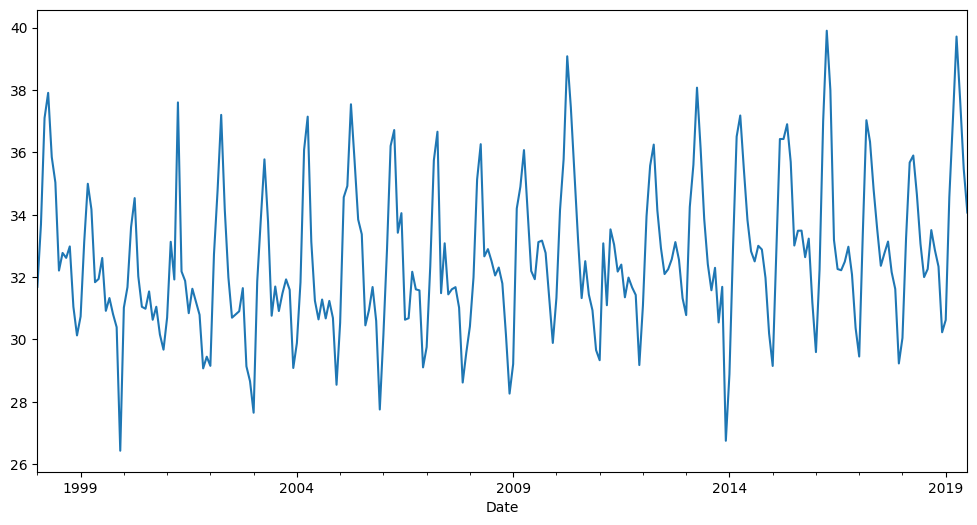

In [9]:
plt.figure(figsize=(12,6))
y.plot();

In [8]:
train = y[:-24]
test = y[-24:]

print(test)

Date
2017-08-31    32.764516
2017-09-30    33.140000
2017-10-31    32.158065
2017-11-30    31.616667
2017-12-31    29.229032
2018-01-31    30.048387
2018-02-28    33.253571
2018-03-31    35.674194
2018-04-30    35.900000
2018-05-31    34.648387
2018-06-30    33.066667
2018-07-31    32.000000
2018-08-31    32.258065
2018-09-30    33.506667
2018-10-31    32.864516
2018-11-30    32.336667
2018-12-31    30.229032
2019-01-31    30.622581
2019-02-28    34.564286
2019-03-31    37.051613
2019-04-30    39.716667
2019-05-31    37.680645
2019-06-30    35.466667
2019-07-31    34.070968
Freq: ME, Name: MaxTemp, dtype: float64


## Test stationarity

### KPSS
- $H_0$: data is stationary
- $H_1$: data is **not** stationary


### ADF
- $H_0$: data is **not** stationary
- $H_1$: data is stationary


In [11]:
from statsmodels.tsa.stattools import adfuller, kpss

def KPSStest(timeseries):
  kpsstest = kpss(timeseries)
  print('KPSS test')
  print('Test Statistic: ',kpsstest[0])
  print('p-value: ',kpsstest[1])
  print('Number of Observations Used: ',kpsstest[2])
  print('Critical Values: ',kpsstest[3])

def ADFtest(timeseries):
  adftest = adfuller(timeseries)
  print('ADF test')
  print('Test Statistic: ',adftest[0])
  print('p-value: ',adftest[1])
  print('#Lags Used: ',adftest[2])
  print('Number of Observations Used: ',adftest[3])
  print('Critical Values: ',adftest[4])

In [12]:
KPSStest(y)
ADFtest(y)

KPSS test
Test Statistic:  0.6428439386603282
p-value:  0.018741460121788345
Number of Observations Used:  4
Critical Values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
ADF test
Test Statistic:  -2.222023197657817
p-value:  0.19834961731512274
#Lags Used:  13
Number of Observations Used:  245
Critical Values:  {'1%': -3.4573260719088132, '5%': -2.873410402808354, '10%': -2.573095980841316}


**ยอมรับ H0 ของ KPSS และ ADF ว่าข้อมูลยังไม่มีลักษณะเป็น Stationary**

In [15]:
y_diff = y-y.shift()
y_diff.dropna(inplace=True)

KPSStest(y_diff)
ADFtest(y_diff)

KPSS test
Test Statistic:  0.04516874529942415
p-value:  0.1
Number of Observations Used:  28
Critical Values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
ADF test
Test Statistic:  -6.227064576112576
p-value:  5.0583827570587737e-08
#Lags Used:  12
Number of Observations Used:  245
Critical Values:  {'1%': -3.4573260719088132, '5%': -2.873410402808354, '10%': -2.573095980841316}


/tmp/ipython-input-3817557194.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries)


**ยอมรับ H1 ของ KPSS และ ADF ว่าข้อมูลยังมีลักษณะเป็น Stationary**

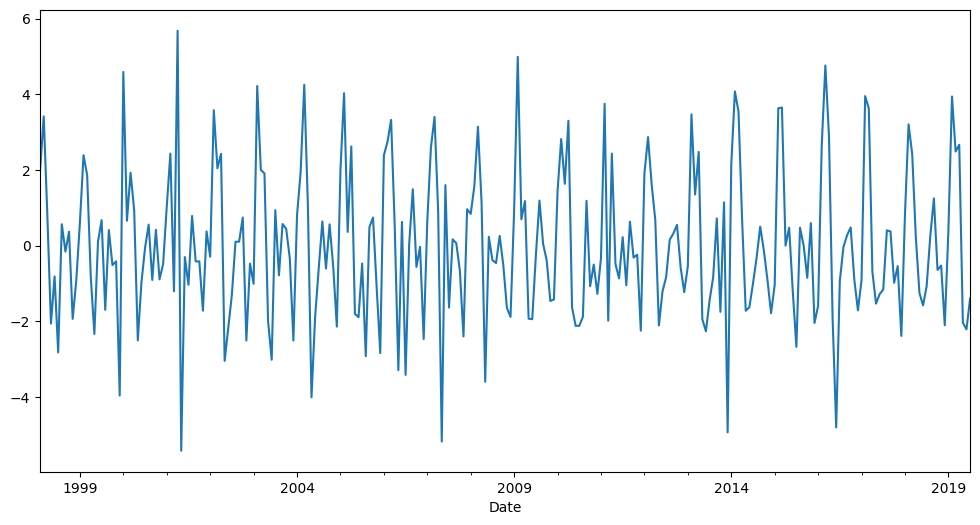

In [14]:
plt.figure(figsize=(12,6))
y_diff.plot();

# ARIMA($p,d,q$)

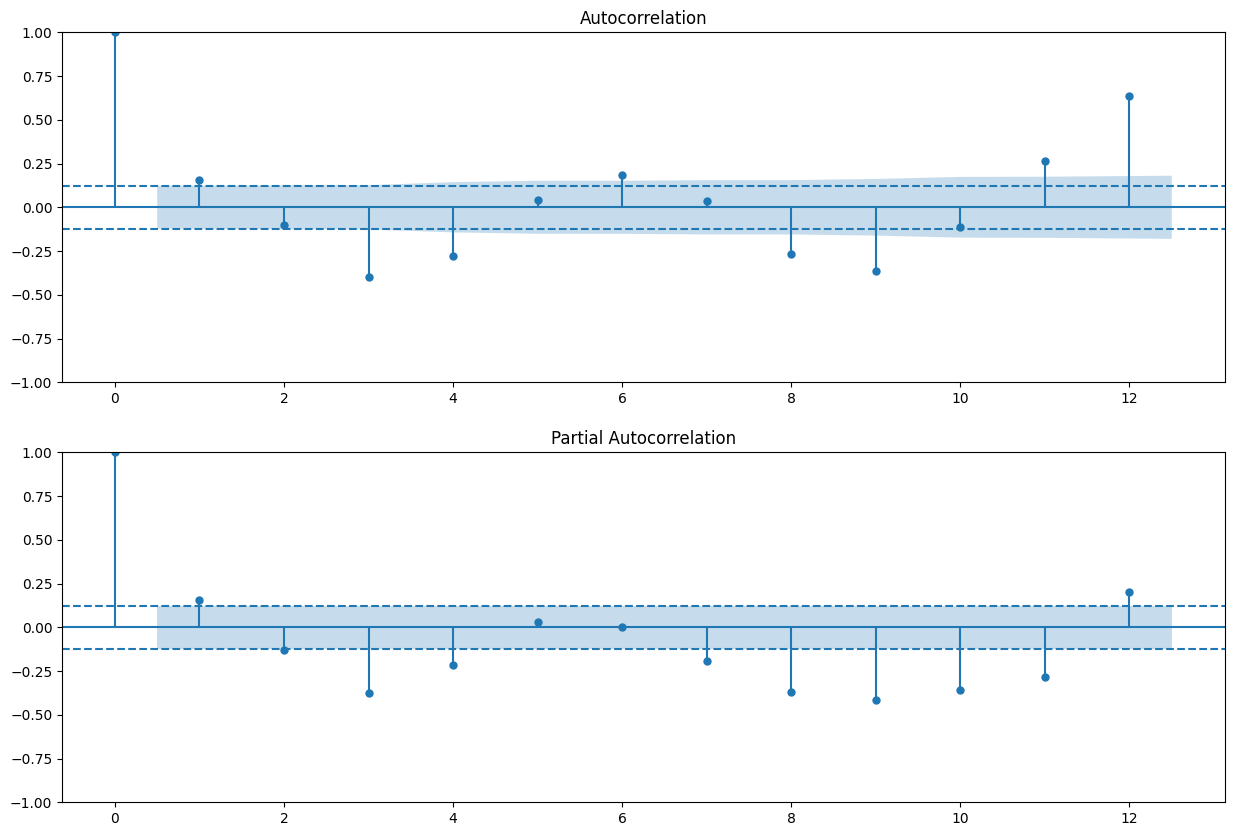

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,1,figsize=(15, 10))

plot_acf(y_diff, lags=12, ax=ax[0]);
ax[0].axhline(y=-1.96/(len(y)-1)**.5, linestyle = '--')
ax[0].axhline(y=1.96/(len(y)-1)**.5, linestyle = '--')

plot_pacf(y_diff, lags=12, ax=ax[1]);
ax[1].axhline(y=-1.96/(len(y)-1)**.5, linestyle = '--')
ax[1].axhline(y=1.96/(len(y)-1)**.5, linestyle = '--')

In [18]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train, order=(3,1,3))


In [20]:
arima_fit = arima.fit()
yhat = arima_fit.predict(start=test.index[0], end=test.index[-1])

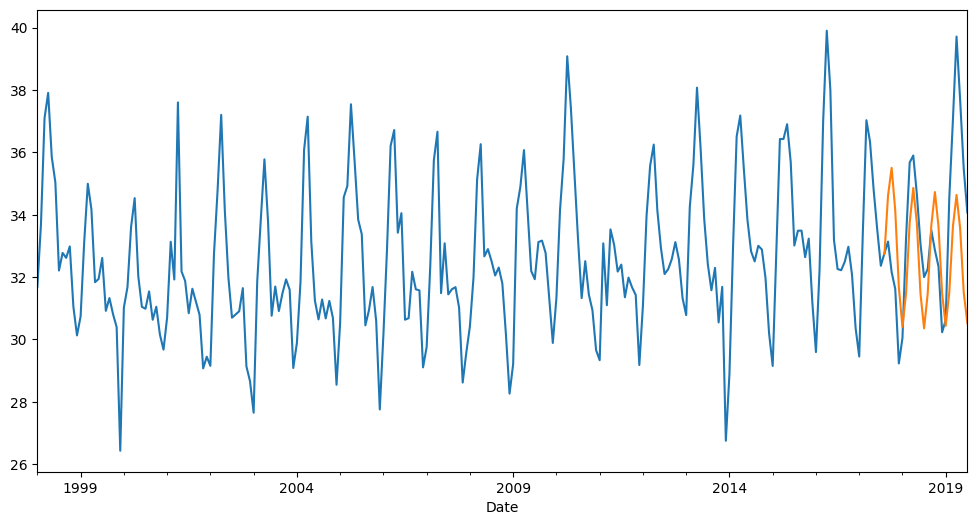

In [21]:
plt.figure(figsize=(12,6))
y.plot()
yhat.plot();

/usr/local/lib/python3.12/dist-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: optimized. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


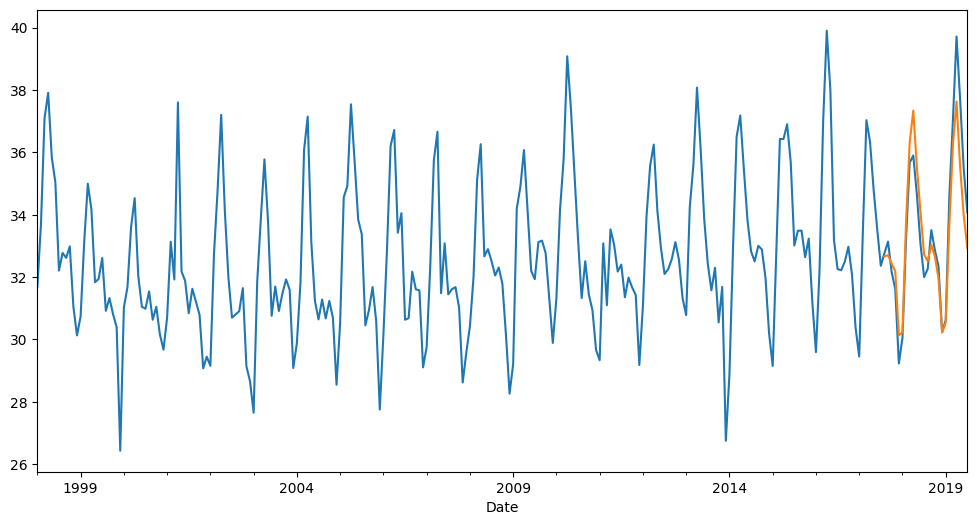

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(train, order=(3, 1, 3), seasonal_order=(1, 1, 1, 12))

sarima_fit = sarima.fit(optimized=True)
yhat = sarima_fit.predict(start=test.index[0], end=test.index[-1])

plt.figure(figsize=(12,6))
y.plot()
yhat.plot();

In [27]:
print('RMSE:',rmse(test,yhat))

RMSE: 0.9353592629378311


### ใช้ `auto_arima` จาก `pmdarima` เพื่อหา order ที่เหมาะสม

In [28]:
import pmdarima as pm

auto_fit = pm.auto_arima(train, start_p=0, start_q=0, max_p=3, max_q=3, d=0,
                             seasonal=True, m=12, start_P=0, start_Q=0, D=0,
                             information_criterion = 'aicc', # choose model with the lowest corrected AIC
                             trace = True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True) # don't want convergence warnings

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aicc
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AICC=1077.722, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AICC=inf, Time=1.37 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AICC=899.760, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AICC=2306.808, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AICC=964.868, Time=0.07 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AICC=789.717, Time=1.31 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,0)[12] intercept   : AICC=829.766, Time=1.13 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,1)[12] intercept   : AICC=inf, Time=4.74 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12] intercept   : AICC=793.416, Time=6.75 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12] intercept   : AICC=866.494, Time=0.74 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,0)[12] intercept   : AICC=798.732, Time=2.53 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,2)[12] intercept   : AICC=854.748, Time=5.58 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AICC=828.944, Time=0.96 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AICC=817.576, Time=1.54 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,1)[12] intercept   : AICC=771.069, Time=1.64 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[12] intercept   : AICC=864.313, Time=0.39 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,0)[12] intercept   : AICC=805.436, Time=1.26 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,0,1)[12] intercept   : AICC=inf, Time=3.21 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,2)[12] intercept   : AICC=inf, Time=8.18 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AICC=921.404, Time=0.11 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,2)[12] intercept   : AICC=833.939, Time=1.01 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,0,0)[12] intercept   : AICC=779.506, Time=2.57 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,0,2)[12] intercept   : AICC=821.819, Time=6.15 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[12] intercept   : AICC=828.539, Time=1.79 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(1,0,1)[12] intercept   : AICC=773.231, Time=1.94 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(1,0,1)[12] intercept   : AICC=inf, Time=1.89 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,1)[12]             : AICC=814.293, Time=1.65 sec

Best model:  ARIMA(0,0,2)(1,0,1)[12] intercept
Total fit time: 58.834 seconds


In [29]:
auto_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  235
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -379.351
Date:                              Thu, 18 Sep 2025   AIC                            770.701
Time:                                      03:10:37   BIC                            791.459
Sample:                                  01-31-1998   HQIC                           779.069
                                       - 07-31-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.8495      1.249      3.083      0.002       1.402       6.297
ma.L1          0.4267      0.061      7.035      0.000       0.308       0.546
ma.L2          0.2919      0.068      4.284      0.000       0.158       0.425
ar.S.L12       0.8814      0.038     23.136      0.000       0.807       0.956
ma.S.L12      -0.4447      0.086     -5.178      0.000      -0.613      -0.276
sigma2         1.4333      0.127     11.254      0.000       1.184       1.683
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 8.41
Prob(Q):                              0.63   Prob(JB):                         0.01
Heteroskedasticity (H):               0.86   Skew:                             0.02
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


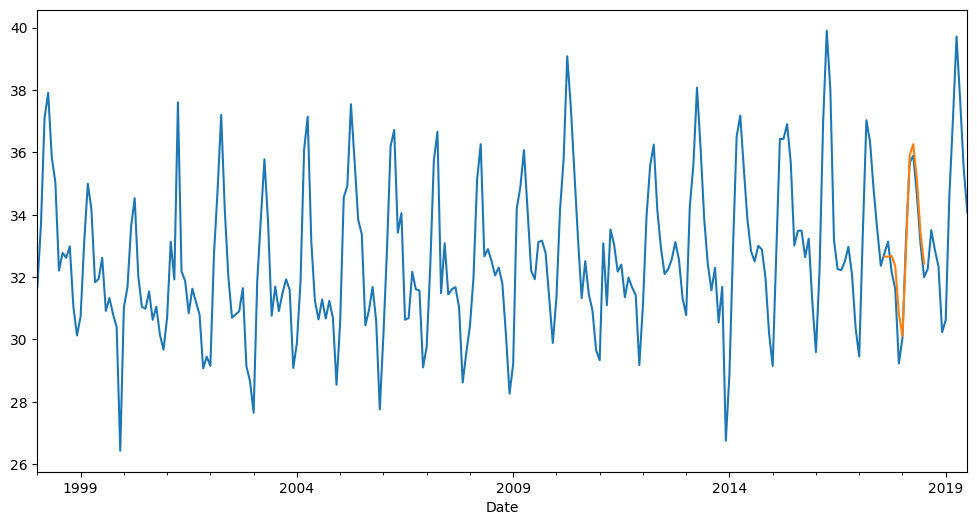

In [32]:
predictions = auto_fit.predict(12)
yhat = pd.Series(predictions,
                    index=test.index)

plt.figure(figsize=(12,6))
ax = y.plot()
yhat.plot(ax=ax);

In [33]:
print('RMSE:',rmse(test,yhat))

RMSE: 0.6093098221278569
